# Chapter 7:
# Decision Tree

Cây quyết định (Decision Tree, viết tắt DT) là một thuật toán ML được sử dụng phổ biến vì tính trực quan dễ giải thích của nó. Thuật toán này áp dụng được cho cả bài toán phân loại (Classification) lẫn hồi quy (Regression). Thuật toán này khá "dễ tính" vì nó chấp nhận cả biến định tính lẫn biến định lượng và cũng không đòi hỏi cao về tiền xử lí số liệu. 

Chương 7 sẽ giải thích bản chất của thuật toán này bằng ngôn ngữ trực quan nhất có thể với sự tham gia tối thiểu của các công thức toán (chúng thường rất phức tạp và trừu tượng) đồng thời khảo sát mức độ ảnh hưởng - hay sự biến đổi chất lượng phân loại của thuật toán DT đối với một số tham số (Hyper-parameters) quan trọng của thuật toán này. Thuật toán DT cùng với ý tưởng của nó được sử dụng để xây dựng và phát triển những mô hình phức tạo hơn như Random Forerst do vậy hiểu được bản chất của thuật toán này là quan trọng. 

## 7.1 Ý tưởng của Decision Tree

Để minh họa chúng ta trở lại với bộ dữ liệu **UniversalBank.csv** nhưng chỉ sử dụng hai features đầu vào là **Income** và **CCAvg**: 

In [1]:
#============================
#    Chuẩn bị dữ liệu 
#============================

# Đọc dữ liệu: 
import pandas as pd
df_bank = pd.read_csv("C:/Users/Zbook/Desktop/DataMining/dmba/UniversalBank.csv")

# Bỏ biến không cần thiết: 
my_df_binary = df_bank.drop(["ZIP Code", "ID"], axis=1) 

# Tách ra features và target: 
Y = my_df_binary["Personal Loan"]
X = my_df_binary.drop("Personal Loan", 1)

# Phân chia dữ liệu theo tỉ lệ 60 - 40: 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.4, random_state = 29, stratify = Y)

# Chỉ lấy hai features: 
some_columns = ["Income", "CCAvg"]

X_train_mini = X_train[some_columns]
X_test_mini = X_test[some_columns]

In [2]:
# Huấn luyện DT trên dữ liệu train và đánh giá chất lượng phân loại trên dữ liệu test: 
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=29, criterion="gini", max_depth=3)
tree.fit(X_train_mini, y_train)

print("Accuracy on training set: {:.3f}".format(tree.score(X_train_mini, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test_mini, y_test)))

Accuracy on training set: 0.914
Accuracy on test set: 0.914


Accuracy là 0.914 trên cả Train lẫn Test data như chúng ta thấy chỉ là sự trùng hợp. Để diễn giải ý tưởng của thuật toán DT, trước hết chúng ta "hình ảnh hóa" thuật toán này: 

In [3]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

from sklearn.tree import export_graphviz
export_graphviz(tree, 
                out_file="tree_mini.dot", 
                class_names=["Yes", "No"],
                feature_names=some_columns, 
                impurity=True, 
                filled=True)

from subprocess import call
call(['dot', '-Tpng', 'tree_mini.dot', '-o', 'tree_mini1.png', '-Gdpi=1000'])

from IPython.display import Image
Image(filename = 'tree_mini1.png')

Thuật toán này bắt đầu bằng câu hỏi *có phải Income nhỏ hơn 112.5?*. Nếu câu trả lời là *Yes* thì sẽ rẽ nhánh sang câu hỏi bên trái là *có phải CCAvg nhỏ hơn 2.95?*. Còn nếu câu trả lời là *No* cho câu hỏi *có phải Income nhỏ hơn 112.5?* thì sẽ rẽ nhánh sang phải với câu hỏi tương ứng là *có phải Income nhỏ hơn 166.5?*. Theo cách nói của thuật toán DT thì: 

- *Có phải Income bé hơn 112.5?* được gọi là gốc xuất phát - **root node** tương ứng với độ sâu là zero (depth 0). 
- *Có phải CCAvg nhỏ hơn 2.95?* được gọi là node con phía trái (left child node) còn *Có phải Income nhỏ hơn 166.5?* là node con phía phải (right child node). Cả hai node này tương ứng với depth = 1. 
- Vì **độ sâu của cây là 3** (tương ứng với max_depth=3) nên thuật toán DT của chúng ta chỉ tăng trưởng (Growing) đến tầng thứ ba là dừng lại. 

Ở đây chúng ta có một số câu hỏi kiểu như sau: **tại sao biến Income và ngưỡng 112.5 được lựa chọn?**. 

## 7.2 CART và điều kiện dừng 

Với bài toán phân loại nhị phân thì Scikit-Learn sử dụng cách tiếp cận có tên là CART (viết tắt của Classifcation And Regression Tree). Cách tiếp cận này sẽ chọn *một feature k và một ngưỡng t* để phân chia các quan sát thành hai tập con nhỏ hơn (Subsets) - tạm gọi là tập con bên phải và tập con bên trái sao cho hàm mất mát (cost function) J được định nghĩa như sau đạt giá trị nhỏ nhất: 

$$J = \frac{M_{left}}{M}(G_{left}) + \frac{M_{right}}{M}(G_{right})$$

Trong đó $M_{left}$ là số quan sát thuộc node con bên trái, $M_{right}$ là số quan sát thuộc node con bên phải, ${M}$ là tổng số quan sát ở cả hai node, $G_{left}$ và $G_{right}$ lần lượt là **mức độ thuần khiết - impurity measure** tương ứng của hai node bên trái và phải. Có hai thước đo chủ yếu được sử dụng để đánh giá mức độ thuần khiết của một tập hợp. Chúng ta sẽ lần lượt tìm hiểu hai thước đo này. 

Mức độ thuần khiết (hay nói ngược lại, độ hỗn loạn của một hệ hay tập hợp) được đo lường bằng chỉ số Gini theo công thức sau: 

$$Gini = 1-\sum_jp_j^2$$. 

Hoặc cũng có thể được đo lường bằng chỉ số Entropy - một khái niệm bắt đầu từ nhiệt động học (thermodynamics) - theo công thức: 
$$Entropy = -\sum_jp_j\log_2p_j$$. 

Với thuật toán DT mà chúng ta đã thực hiện thì tiêu chí đánh giá mức độ thuần nhất của dữ liệu là Gini (tương ứng với lựa chọn criterion="gini"). Với mô tả đã biết về Gini thì chúng ta dễ dành tìm lại được Gini = 0.174 (làm tròn đến 3 chữ số sau dấu thập phân) cho root node như sau:  

$$Gini = 1 - \left( \left(\frac{2712}{3000} \right)^2 + \left(\frac{288}{3000}\right)^2 \right) = 1 - 0.817 - 0.009 =  0.174$$. 

Tương tự chúng ta có thể tính toán Gini cho các Node còn lại. Thuật toán DT sẽ sử dụng cùng một logic là phân chia tiếp các subsets thành các tập nhỏ hơn sao cho J nhỏ nhất cho đến khi nào đạt đến độ sâu tối đa max depth hoặc nó sẽ dừng lại khi nào mà không thể tìm được một sự phân chia nào có thể làm giảm mức độ thuần khiết của tập dữ liệu. 

## 7.3 Chọn Gini hay Entropy?

Mặc định thì Scikit-Learn sẽ chọn Gini như là thước đo đánh giá mức độ thuần khiết khi phân chia dữ liệu vì DT với lựa chọn này chạy nhanh hơn một chút. Sự thực thì trong hầu hết các tình huống **không có sự khác biệt đáng kể nào về chất lượng phân loại của mô hình bất kể là thước đo được sử dụng là Gini hay Entropy**. Tiêu chuẩn Gini có xu hướng tạo ra sự khác biệt - hay cách li lớn nhất có thể đối với các nhãn khác nhau trong khi Entropy thì có xu hướng tạo ra các cây với các nhãn được phân bố cân bằng hơn ở các node. 

## 7.4 Feature Importance (FI)

Thuật toán DT cho phép đánh giá mức độ quan trọng (Feature Importance, FI) - hay vai trò của biến số đến khả năng phân biệt của mô hình. Trước hết chúng ta huấn luyện lại DT với toàn bộ features: 

In [4]:
tree_full = DecisionTreeClassifier(max_depth=5, random_state=29)
tree_full.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(tree_full.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree_full.score(X_test, y_test)))

Accuracy on training set: 0.990
Accuracy on test set: 0.982


Hình ảnh hóa mô hình DT: 

In [5]:
feature_names = list(X_train)
export_graphviz(tree_full, 
                out_file="tree_full.dot", 
                class_names=["Yes", "No"],
                feature_names=feature_names, 
                impurity=True, 
                filled=True)

call(['dot', '-Tpng', 'tree_full.dot', '-o', 'tree_full.png', '-Gdpi=1000'])
Image(filename = 'tree_full.png')

Nhiều thuật toán cũng đánh giá FI nên chúng ta nên viết một hàm hình ảnh hóa tầm quan trọng của các biến số cho mục đích tái sử dụng nếu cần: 

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

def plot_importance(model_selected):
    n_features = X_train.shape[1]
    df = pd.DataFrame({"Imp": model_selected.feature_importances_, "Feature": feature_names})
    df = df.sort_values(by=["Imp"])
    df.plot(kind = 'barh', legend = False, figsize = (9, 5))
    plt.yticks(np.arange(n_features), df["Feature"])
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.grid(b=None, axis="y")

Với hàm đã có thì: 

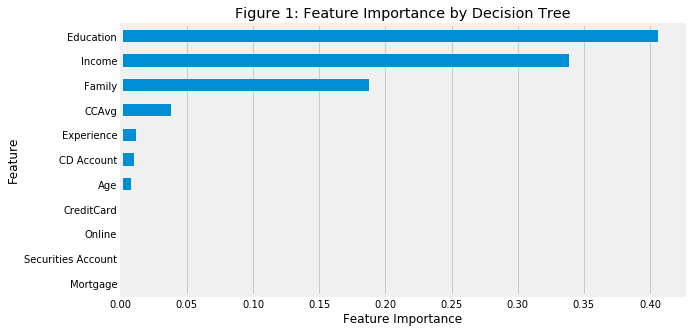

In [7]:
plot_importance(model_selected=tree_full)
plt.title("Figure 1: Feature Importance by Decision Tree")
plt.show()

Figure 1 cho thấy Education và Income là hai biến số có ảnh hưởng lớn nhất đến khả năng phân loại - phân biệt của mô hình. Dựa trên thông tin này chúng ta có thể đánh giá lại chất lượng phân loại của DT nếu, ví dụ, chỉ sử dụng 4 biến quan trọng nhất:  

In [8]:
some_features = ['Education', 'Income', 'Family', 'CCAvg']
X_train_mini = X_train.loc[:, some_features]
X_test_mini = X_test.loc[:, some_features]

tree_mini = DecisionTreeClassifier(max_depth=5, random_state=39)
tree_mini.fit(X_train_mini, y_train)

print("Accuracy on training set: {:.3f}".format(tree_mini.score(X_train_mini, y_train)))
print("Accuracy on test set: {:.3f}".format(tree_mini.score(X_test_mini, y_test)))

Accuracy on training set: 0.987
Accuracy on test set: 0.978


Với 4 biến số này làm features đầu vào thì chất lượng phân loại của mô hình giảm rất ít. 

## 7.5 Một số tham số quan trọng cho DT

Để đánh giá chất thay đổi về chất lượng phân loại của mô hình trước hết phải có một tiêu chí được chọn. Với bài toán phân loại nhị phân thì ROC/AUC là tiêu chuẩn được sử dụng phổ biến. Python Codes dưới đây sẽ đánh giá biến đổi của ROC/AUC trên cả Train và Test Data tương ướng với max_depth từ 1 đến 25: 

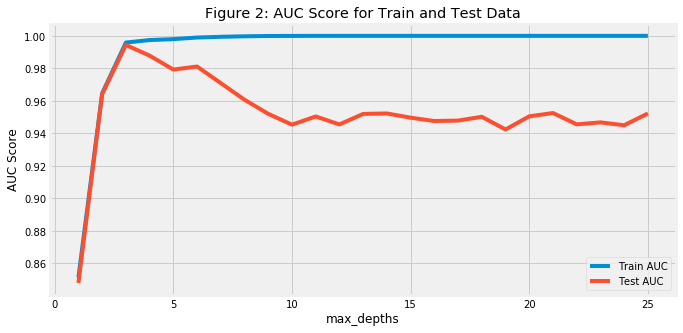

In [9]:
#=============================================
#  Khảo sát biến đổi của AUC theo max_depth
#=============================================

from sklearn.metrics import roc_auc_score

# Tạo chuỗi 25 giá trị của max_depth: 
max_depths = np.linspace(1, 25, 25, endpoint=True)

# Khởi tạo hai list trống (space list) để lưu kết quả: 
train_results = []
test_results = []

# Chạy vòng lặp for loop tính toán AUC cho train và test data: 

for i in max_depths:
    
    # Huấn luyện Decision Tree (DT): 
    dt = DecisionTreeClassifier(max_depth=i)
    dt.fit(X_train, y_train)
    
    # Tính toán AUC tương ứng cho train và test data: 
    auc_test = roc_auc_score(y_test, dt.predict_proba(X_test)[:, 1])
    auc_train = roc_auc_score(y_train, dt.predict_proba(X_train)[:, 1])
    
    # Tạo chuỗi AUC tương ứng với 25 giá trị của max_depths: 
    train_results.append(auc_train)
    test_results.append(auc_test)
    
# Hình ảnh hóa biến đổi của AUC theo max_depths:

plt.figure(figsize=(10, 5))
plt.plot(max_depths, train_results, label = "Train AUC")
plt.plot(max_depths, test_results, label = "Test AUC")
plt.legend()
plt.xlabel("max_depths")
plt.ylabel("AUC Score")
plt.title("Figure 2: AUC Score for Train and Test Data") 
plt.show()

Figure 2 cho thấy AUC cho Test Data đạt cao nhất nếu max_depth = 3. Sau ngưỡng này thì AUC trên Test Data giảm. Với Train Data thì sau ngưỡng max_depth = 3 thì AUC gần như không tăng gì. Kết quả của khảo sát này cho thấy: khi mọi thứ khác cố định thì max_depth = 3 là tham số tối ưu. 

Tương tự là Python Codes để khảo sát một số tham số quan trọng khác của thuật toán DT. 

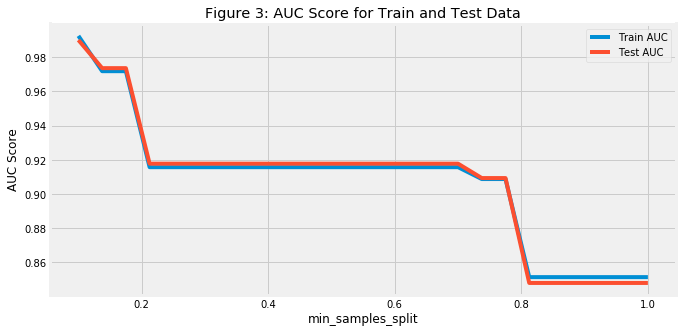

In [10]:
#=====================================================
#  Khảo sát biến đổi của AUC theo min_samples_splits
#=====================================================

# Tạo chuỗi 25 giá trị của min_samples_splits:  
min_samples_splits = np.linspace(0.1, 1.0, 25, endpoint=True)

# Khởi tạo hai list trống (space list) để lưu kết quả: 
train_results = []
test_results = []

# Chạy vòng lặp for loop tính toán AUC cho train và test data: 

for i in min_samples_splits:
    
    # Huấn luyện Decision Tree (DT): 
    dt = DecisionTreeClassifier(min_samples_split=i)
    dt.fit(X_train, y_train)
    
    # Tính toán AUC tương ứng cho train và test data: 
    auc_test = roc_auc_score(y_test, dt.predict_proba(X_test)[:, 1])
    auc_train = roc_auc_score(y_train, dt.predict_proba(X_train)[:, 1])
    
    # Tạo chuỗi AUC tương ứng với 25 giá trị của max_depths: 
    train_results.append(auc_train)
    test_results.append(auc_test)
    
# Hình ảnh hóa biến đổi của AUC: 

plt.figure(figsize=(10, 5))
plt.plot(min_samples_splits, train_results, label = "Train AUC")
plt.plot(min_samples_splits, test_results, label = "Test AUC")
plt.legend()
plt.xlabel("min_samples_split")
plt.ylabel("AUC Score")
plt.title("Figure 3: AUC Score for Train and Test Data") 
plt.show()

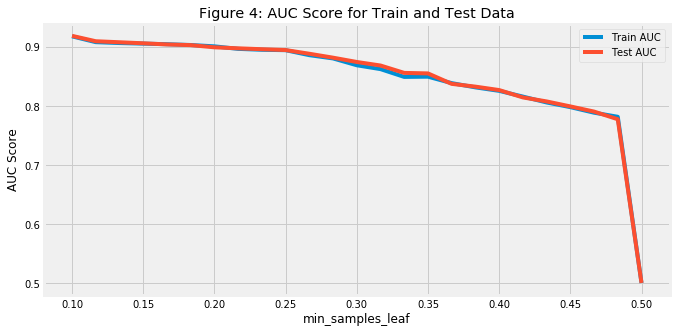

In [11]:
#=====================================================
#  Khảo sát biến đổi của AUC theo min_samples_leaf
#=====================================================

# Tạo chuỗi 25 giá trị của min_samples_leaf:  
min_samples_leafs = np.linspace(0.1, 0.5, 25, endpoint=True)

# Khởi tạo hai list trống (space list) để lưu kết quả: 
train_results = []
test_results = []

# Chạy vòng lặp for loop tính toán AUC cho train và test data: 

for i in min_samples_leafs:
    
    # Huấn luyện Decision Tree (DT): 
    dt = DecisionTreeClassifier(min_samples_leaf=i)
    dt.fit(X_train, y_train)
    
    # Tính toán AUC tương ứng cho train và test data: 
    auc_test = roc_auc_score(y_test, dt.predict_proba(X_test)[:, 1])
    auc_train = roc_auc_score(y_train, dt.predict_proba(X_train)[:, 1])
    
    # Tạo chuỗi AUC tương ứng với 25 giá trị của max_depths: 
    train_results.append(auc_train)
    test_results.append(auc_test)
    
# Hình ảnh hóa biến đổi của AUC: 

plt.figure(figsize=(10, 5))
plt.plot(min_samples_leafs, train_results, label = "Train AUC")
plt.plot(min_samples_leafs, test_results, label = "Test AUC")
plt.legend()
plt.xlabel("min_samples_leaf")
plt.ylabel("AUC Score")
plt.title("Figure 4: AUC Score for Train and Test Data") 
plt.show()

## 7.6 Tinh chỉnh tham số cho thuật toán DT

Giả sử chúng ta chọn chỉ 4 tham số để tinh chỉnh là max_depth, min_samples_split, min_samples_leaf và max_features: 

In [12]:
# Định nghĩa các ứng viên tiềm năng cho tham số: 
param_grid = {"max_depth": np.linspace(1, 10, 10, endpoint=True), 
              "min_samples_split": np.linspace(0.1, 0.5, 10, endpoint=True), 
              "min_samples_leaf": np.linspace(0.1, 0.4, 10, endpoint=True), 
              "max_features": range(1, 9)}

In [13]:
# Load GridSearchCV: 
from sklearn.model_selection import GridSearchCV

# Thiết lập môi trường tinh chỉnh: 
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring = "accuracy", n_jobs=-1, verbose = 2)

# Tinh chỉnh tham số và tính thời gian tinh chỉnh + huấn luyện: 

import time
start_time = time.time()
grid_search.fit(X_train, y_train)

# In ra giá trị của các tham số tối ưu cùng AUC tương ứng: 

print('Training Time:', time.time() - start_time)
print("Các tham số tối ưu:", grid_search.best_params_)

Fitting 5 folds for each of 8000 candidates, totalling 40000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 1973 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 6845 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 13637 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 22397 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 33077 tasks      | elapsed:   36.8s


Training Time: 44.82023286819458
Các tham số tối ưu: {'max_depth': 10.0, 'max_features': 6, 'min_samples_leaf': 0.1, 'min_samples_split': 0.18888888888888888}


[Parallel(n_jobs=-1)]: Done 40000 out of 40000 | elapsed:   44.6s finished


In [14]:
# Thực hiện Random Search: 
from sklearn.model_selection import RandomizedSearchCV

start_time = time.time()

dt_random = RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=29),
                               param_distributions=param_grid,
                               cv=5,              
                               n_iter=1000,         
                               scoring="accuracy",
                               n_jobs=-1,           
                               random_state=29)

dt_random.fit(X_train, y_train)

# Hiển thị thời gian cần thiết để tinh chỉnh: 
print('Training Time:', time.time() - start_time)

Training Time: 7.141894340515137


In [15]:
# Tham số tốt nhất theo phương án Random Search: 
print(dt_random.best_params_) 

{'min_samples_split': 0.4555555555555556, 'min_samples_leaf': 0.1, 'max_features': 6, 'max_depth': 3.0}


Ngoài tinh chỉnh theo Grid Search và Random Search chúng ta cũng có thể sử dụng một chiến lược tinh chỉnh khác hiệu quả hơn cả về mặt thời gian lẫn chất lượng phân loại của mô hình bằng Bayesian Optimization được trình bày chi tiết ở [chương 6](https://github.com/ChiDungNguyen/Chapter6_Bayesian_Optimization-RandomForest-/blob/master/Chapter6_Bayesian_Optimization_For_Turning_Parameters.ipynb). 

## 7.6 Tóm tắt chương

Chương này giới thiệu một cách trực quan cách thức mà thuật toán DT được xây dựng và hình thành. Một số tham số quan trọng (theo quan điểm của người viết) của thuật toán DT cũng được khảo sát và đánh giá. Một số khía cạnh khác của mô hình DT như áp dụng cho bài toán Regression không được trình bày trong chương này. 

## Tài liệu tham khảo

1. Géron, A. (2019). Hands-on machine learning with Scikit-Learn and TensorFlow: concepts, tools, and techniques to build intelligent systems. O'Reilly Media, Inc.
2. Shmueli, G., Bruce, P. C., Yahav, I., Patel, N. R., & Lichtendahl Jr, K. C. (2017). Data mining for business analytics: concepts, techniques, and applications in R. John Wiley & Sons.
3. Zekic-Susac, M., Sarlija, N., & Bensic, M. (2004, June). Small business credit scoring: a comparison of logistic regression, neural network, and decision tree models. In 26th International Conference on Information Technology Interfaces, 2004. (pp. 265-270). IEEE.
4. Bensic, M., Sarlija, N., & Zekic‐Susac, M. (2005). Modelling small‐business credit scoring by using logistic regression, neural networks and decision trees. Intelligent Systems in Accounting, Finance & Management: International Journal, 13(3), 133-150.
5. Ma, H., Qin, M., & Wang, J. (2009, August). Analysis of the business customer churn based on decision tree method. In 2009 9th International Conference on Electronic Measurement & Instruments (pp. 4-818). IEEE.